In [68]:
from google.colab import drive
drive.mount('/content/drive')
root_path = "/content/drive/My Drive/flight_ticket_price_prediction/Input"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [132]:
df_train = pd.read_excel(os.path.join(root_path, 'Data_Train.xlsx'))
df_test = pd.read_excel(os.path.join(root_path, 'Test_set.xlsx'))

In [ ]:
print(f'Training: {df_train.shape}')
print(f'Testing: {df_test.shape}')

Training: (10682, 11)
Testing: (2671, 10)


In [ ]:
df_train.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
df_test.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


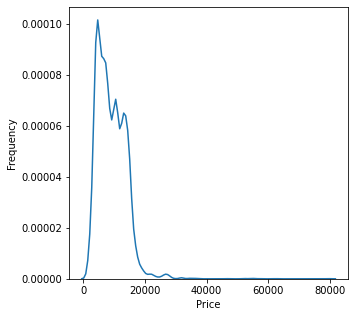

In [ ]:
plt.figure(figsize=(5,5))
sns.distplot(df_train['Price'], hist=False, kde=True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_train['Price'].describe()

count    10683.000000
mean      9087.064121
std       4611.359167
min       1759.000000
25%       5277.000000
50%       8372.000000
75%      12373.000000
max      79512.000000
Name: Price, dtype: float64

In [133]:
df_train['Price'] = np.log1p(df_train.Price)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [ ]:
df_train.isnull().sum()
#df_test.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [134]:
df_train.dropna(axis=0, inplace=True)

In [149]:
df_train.drop(index=6474, axis=0, inplace=True)
df_test.loc[df_test['Duration'] == '5m', 'Duration'] = '11h 50m'

In [151]:
train_count = df_train.shape[0]

In [150]:
df_full = df_train.append(df_test, ignore_index=True)
df_full.tail(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
13347,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,NaN
13348,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,NaN
13349,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,NaN
13350,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,NaN
13351,Multiple carriers,15/06/2019,Delhi,Cochin,DEL → BOM → COK,04:55,19:15,14h 20m,1 stop,No info,NaN


In [ ]:
def getValueCounts(df, colname):
  df_CountSer = df[colname].value_counts()
  return pd.DataFrame({colname:df_CountSer.index, 'count':df_CountSer.values})
getValueCounts(df_full, 'Airline')

,Airline,count
0,Jet Airways,4746
1,IndiGo,2564
2,Air India,2191
3,Multiple carriers,1543
4,SpiceJet,1026
5,Vistara,608
6,Air Asia,405
7,GoAir,240
8,Multiple carriers Premium economy,16
9,Jet Airways Business,8


In [ ]:
print(getValueCounts(df_full, 'Source'))
print('--------------')
print(getValueCounts(df_full, 'Destination'))

     Source  count
0     Delhi   5681
1   Kolkata   3581
2  Banglore   2752
3    Mumbai    883
4   Chennai    456
--------------
  Destination  count
0      Cochin   5681
1    Banglore   3581
2       Delhi   1582
3   New Delhi   1170
4   Hyderabad    883
5     Kolkata    456


In [ ]:
getValueCounts(df_full, 'Total_Stops')

,Total_Stops,count
0,1 stop,7056
1,non-stop,4340
2,2 stops,1899
3,3 stops,56
4,4 stops,2


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


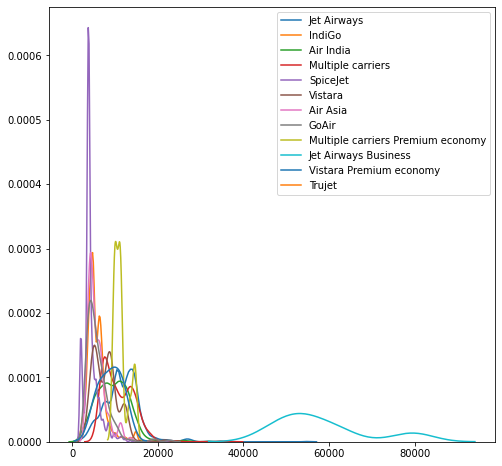

In [ ]:
airlines = []
airlines = (df_train['Airline'].value_counts()).index
plt.figure(figsize=(8,8))
for i in airlines:
  df_1 = df_train.loc[df_train['Airline'] == i, 'Price']
  sns.kdeplot(df_1, label=i)
plt.show()

In [152]:
df_full['Destination'].replace(to_replace='New Delhi', value='Delhi', inplace=True)

In [153]:
df_full['Additional_Info'].replace(to_replace='No Info', value='No info', inplace=True)

In [154]:
import re

def change_to_min(stime):
  h =  str(stime).split(':')[0].strip()
  m = 0
  if len(str(stime).split(':')) > 1:
    m = str(stime).split(':')[1].strip()
  return int(h)*60 + int(m)

def insert_min(stime):
  stimetemp = re.sub(r"^(\d+)h$", r"\1", stime)
  stimetemp = re.sub(r"^(\d+)h\s(\d+)m", r"\1:\2", stimetemp)
  return change_to_min(stimetemp)

df_full['duration_min'] = df_full['Duration'].apply(lambda x: insert_min(x))

In [155]:
def changeDate(df):
  df['doj'] = pd.to_datetime(df['Date_of_Journey'])
  #df['date_of_journey'] = df['doj'].dt.date
  df['day_of_journey'] = df['doj'].dt.day
  df['month_of_journey'] = df['doj'].dt.month
  df['week_of_journey'] = df['doj'].dt.weekday
  df['month_st_journey'] = df['doj'].dt.is_month_start.astype('int')
  df['month_ed_journey'] = df['doj'].dt.is_month_end.astype('int')
  #return df

changeDate(df_full)

In [156]:
df_routes = df_full['Route'].str.split(expand=True).drop(columns=[1,3,5,7,9], 
                                                        axis=1).rename(columns={0:'Route_1',
                                                                                2:'Route_2',
                                                                                4:'Route_3',
                                                                                6:'Route_4',
                                                                                8:'Route_5',
                                                                                10:'Route_6'}).fillna(0)

In [157]:
stop_loc = {}
location = df_full['Route'].str.split(' → ')
for l in location:
  for r in l:
    if r not in stop_loc:
      stop_loc[r] = 1
    else:
      stop_loc[r] += 1

In [158]:
df_routes['Route_1'] = df_routes['Route_1'].map(stop_loc).fillna(0)
df_routes['Route_2'] = df_routes['Route_2'].map(stop_loc).fillna(0)
df_routes['Route_3'] = df_routes['Route_3'].map(stop_loc).fillna(0)
df_routes['Route_4'] = df_routes['Route_4'].map(stop_loc).fillna(0)
df_routes['Route_5'] = df_routes['Route_5'].map(stop_loc).fillna(0)
df_routes['Route_6'] = df_routes['Route_6'].map(stop_loc).fillna(0)

In [159]:
df_full_1 = pd.concat([df_full,df_routes], axis=1)

In [160]:
df_full_1['doj'] = df_full_1['doj'].astype(np.int) / df_full_1['doj'].astype(np.int).min()

In [121]:
df_full_1.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'duration_min', 'doj', 'date_of_journey',
       'day_of_journey', 'month_of_journey', 'week_of_journey',
       'month_st_journey', 'month_ed_journey', 'Stop_1', 'Stop_2', 'Stop_3',
       'Stop_4', 'Stop_5', 'Stop_6'],
      dtype='object')

In [161]:
obj_cols = ['Airline','Total_Stops','Additional_Info']

df_source = pd.get_dummies(df_full_1['Source'], prefix='s')
df_destination = pd.get_dummies(df_full_1['Destination'], prefix='d')
df_obj_cols = pd.get_dummies(df_full_1[obj_cols], prefix="", prefix_sep="")

In [163]:
to_drop = ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
           'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
           'Additional_Info']

In [164]:
df_full = pd.concat([df_full_1,df_source,df_destination,df_obj_cols],axis=1).drop(columns=to_drop, axis=1)
df_full.head()

,Price,duration_min,doj,day_of_journey,month_of_journey,week_of_journey,month_st_journey,month_ed_journey,Route_1,Route_2,Route_3,Route_4,Route_5,Route_6,s_Banglore,s_Chennai,s_Delhi,s_Kolkata,s_Mumbai,d_Banglore,d_Cochin,d_Delhi,d_Hyderabad,d_Kolkata,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,1 stop,2 stops,3 stops,4 stops,non-stop,1 Long layover,1 Short layover,2 Long layover,Business class,Change airports,In-flight meal not included,No check-in baggage included,No info,Red-eye flight
0,8.268219,170,1.004470,24,3,6,0,0,6627,9414,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,8.944159,445,1.000112,5,1,5,0,0,4135,69,158.0,6627.0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,9.538420,1140,1.013744,6,9,4,0,0,9414,72,7150.0,5795.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,8.735364,325,1.018772,5,12,3,0,0,4135,132,6627.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,9.495745,285,1.000000,3,1,3,0,0,6627,132,9414.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [165]:
train = df_full[:train_count]
test = df_full[train_count:]

print(f'train shape {train.shape}')
print(f'test shape {test.shape}')

train shape (10681, 50)
test shape (2671, 50)


In [166]:
X = train.drop(columns='Price', axis=1)
features = X.columns
y = train['Price']
test.drop(columns='Price', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [168]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [169]:
scaler = sc.fit(X)

In [170]:
X_sc = scaler.transform(X)
test_sc = scaler.transform(test)

In [173]:
X_sc = pd.DataFrame(X_sc, columns=features)
test_sc = pd.DataFrame(test_sc, columns=features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.20, random_state=3)

In [176]:
rfr = RandomForestRegressor()
reg2 = rfr.fit(X_train, y_train)

In [177]:
float(format(reg2.score(X_test, y_test), '.3f'))

0.923

In [178]:
final_prediction = np.expm1(reg2.predict(test_sc))
final_prediction

array([14872.78659987,  4413.26224955, 12898.        , ...,
       16312.52397094, 14604.990471  ,  7540.2151417 ])

In [179]:
output_path = os.path.join(root_path, 'submit-1.csv')
pd.DataFrame(final_prediction, columns=['Price']).to_csv(output_path)